In [1]:
import IPython
import json
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler

sys.path.append("../../")
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.calc.conv import *

In [2]:
da_path = "/Users/jane03/workspaces/music/didge/didge-archive"
didge_archive = json.load(open(os.path.join(da_path, "didge-archive.json")))
arusha = didge_archive[1]
print(json.dumps(arusha, indent=4))

{
    "name": "Arusha",
    "stl-files": [
        "stl-files/arusha.zip"
    ],
    "blender-files": [
        "blender-files/arusha.blend.zip"
    ],
    "audio-samples": {
        "hand-open": "audio-samples/arusha-hand1.wav",
        "hand-closed": "audio-samples/arusha-hand2.wav",
        "neutral-sound": "audio-samples/arusha-neutral-sound.wav",
        "song": "audio-samples/arusha-song.wav"
    },
    "geometry": "geometries/arusha.json",
    "shape": "saxodidge"
}


In [3]:
arusha["audio-samples"].keys()

dict_keys(['hand-open', 'hand-closed', 'neutral-sound', 'song'])

In [4]:
files = {}
for key, value in arusha["audio-samples"].items():
    path = os.path.join(da_path, value)
    files[key] = path

IPython.display.Audio(files["hand-open"])


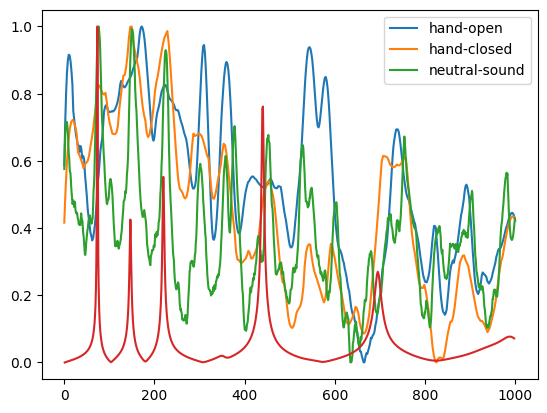

In [5]:
from scipy.signal import savgol_filter

def analyze_wav(infile):
    fft_freq, fft = do_fft(infile)
    fft = np.log2(fft)
    fft = savgol_filter(fft, 20, 3)
    return fft_freq, fft

def minmax(X):
    X2 = X.reshape(-1, 1)
    return MinMaxScaler().fit_transform(X2, X2).reshape((len(X)))

ffts = {}
for key in ['hand-open', 'hand-closed', 'neutral-sound']:
    label = arusha["audio-samples"][key]
    infile = os.path.join(da_path, label)
    fft_freq, fft = analyze_wav(infile)
    ffts[key] = (fft_freq, fft)
    fft = minmax(fft)
    plt.plot(fft_freq, fft, label=key)

geo = json.load(open(os.path.join(da_path, arusha["geometry"])))
geo = Geo(geo)

freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)
impedances = minmax(impedances)
ffts["simulation"] = (freqs, impedances)
plt.plot(freqs, impedances)
plt.legend("simulation")

plt.legend()


In [6]:
df = []
for key in ffts.keys():
    freq, fft = ffts[key]
    indexer = np.logical_and(freq > 60, freq<100)
    i = np.argmax(fft[indexer])
    df.append((key, freq[indexer][i]))
    

pd.DataFrame(df, columns=["sound", "fundamental"])

,sound,fundamental
0,hand-open,94.000000
1,hand-closed,76.190476
2,neutral-sound,75.885714
3,simulation,73.516695


In [7]:
note_to_freq(-31, base_freq=456)

76.08587168769195

In [8]:
freq_to_note_and_cent(75.452667, base_freq=456)

(-31, -14.468027802319483)

In [9]:
for i in range(74, 79):
    print(i, freq_to_note_and_cent(i, base_freq=456))


74 (-31, -48.123978242949406)
75 (-31, -24.88558840263302)
76 (-31, -1.9550008653872908)
77 (-31, 20.675831836191705)
78 (-31, 43.0146456370089)
